In [1]:
pip install opencv-python pillow numpy scikit-learn tensorflow torch torchvision


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr


In [3]:
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, img_size)  # Resize image
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return images


In [5]:
noisy_folder_path = 'D:\Train\Train\low' # change path accordingly 
clean_folder_path = 'D:\Train\Train\high' # change path accordingly
img_size = (128, 128)  # Desired image size

noisy_images = load_images_from_folder(noisy_folder_path, img_size)
clean_images = load_images_from_folder(clean_folder_path, img_size)

In [6]:
train_noisy, test_noisy, train_clean, test_clean = train_test_split(
    noisy_images, clean_images, test_size=0.2, random_state=42
)


In [7]:
def preprocess_image(image):
    return tf.image.convert_image_dtype(image, tf.float32)

# Create TensorFlow datasets
train_noisy_ds = tf.data.Dataset.from_tensor_slices(train_noisy).map(preprocess_image).batch(32)
train_clean_ds = tf.data.Dataset.from_tensor_slices(train_clean).map(preprocess_image).batch(32)
test_noisy_ds = tf.data.Dataset.from_tensor_slices(test_noisy).map(preprocess_image).batch(32)
test_clean_ds = tf.data.Dataset.from_tensor_slices(test_clean).map(preprocess_image).batch(32)

# Combine noisy and clean images for training
train_ds = tf.data.Dataset.zip((train_noisy_ds, train_clean_ds))
test_ds = tf.data.Dataset.zip((test_noisy_ds, test_clean_ds))


In [8]:
def create_denoising_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model

input_shape = (128, 128, 3)
model = create_denoising_model(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,731 (194.26 KB)

 Trainable params: 49,731 (194.26 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(train_ds, epochs=50, validation_data=test_ds)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - loss: 0.0466 - val_loss: 0.0369
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - loss: 0.0360 - val_loss: 0.0327
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 402ms/step - loss: 0.0323 - val_loss: 0.0295
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step - loss: 0.0299 - val_loss: 0.0325
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 406ms/step - loss: 0.0316 - val_loss: 0.0289
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 415ms/step - loss: 0.0283 - val_loss: 0.0269
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step - loss: 0.0276 - val_loss: 0.0267
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 402ms/step - loss: 0.0269 - val_loss: 0.0262
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step - loss: 0.0267 - val_loss: 0.0260
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step - loss: 0.0266 - val_loss: 0.0257
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step - loss: 0.0259 - val_loss: 0.0255
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step

In [10]:
predicted_images = model.predict(test_noisy_ds)

psnr_values = [psnr(test_clean[i], predicted_images[i]) for i in range(len(test_clean))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
Average PSNR: 17.222456442401676


C:\Users\Ram Chhabra\AppData\Local\Temp\ipykernel_53644\69829370.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_values = [psnr(test_clean[i], predicted_images[i]) for i in range(len(test_clean))]


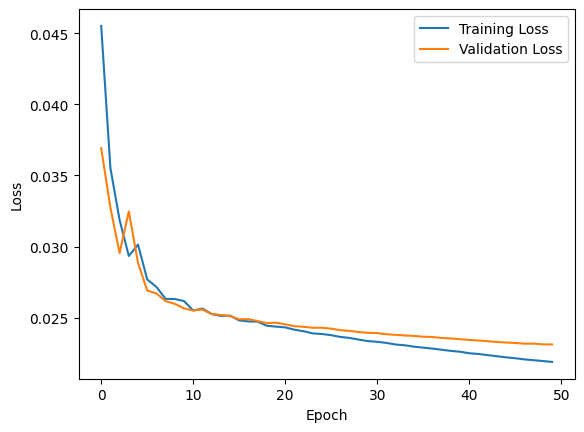

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()